In [0]:
import pandas as pd
import sklearn 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix


In [0]:
tweets = pd.read_csv('sentiment_tweets3.csv')

In [0]:
import string
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk 
nltk.download('punkt')
nltk.download('stopwords')
def preprocess_tweet(text):

    # Check characters to see if they are in punctuation
    nopunc = [char for char in text if char not in string.punctuation]
    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    # convert text to lower-case
    nopunc = nopunc.lower()
    # remove URLs
    nopunc = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', '', nopunc)
    nopunc = re.sub(r'http\S+', '', nopunc)
    # remove usernames
    nopunc = re.sub('@[^\s]+', '', nopunc)
    # remove the # in #hashtag
    nopunc = re.sub(r'#([^\s]+)', r'\1', nopunc)
    # remove repeated characters
    nopunc = word_tokenize(nopunc)
    # remove stopwords from final word list
    return " ".join([word for word in nopunc if word not in stopwords.words('english')])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
preprocessed_tweet_data = []
for tweet in tweets["message"]:
  preprocessed_tweet_data.append(preprocess_tweet(tweet))

In [0]:
from bert_embedding import BertEmbedding
bert_embedding = BertEmbedding()

Vocab file is not found. Downloading.


In [0]:
import numpy as np
import torch
tweets_vectors = []
labels = []
for tweet, lab in zip(preprocessed_tweet_data, tweets["label"]) :
  result = bert_embedding([tweet])
  
  overall_embeddings = np.mean(result[0][1], axis=0)
  if overall_embeddings.shape==(768,):
    tweets_vectors.append(torch.tensor(overall_embeddings))
    labels.append(lab)


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars


In [0]:
knn_vect = []
knn_label = []
for vec, lab in zip(tweets_vectors, labels):
  knn_vect.append(list(tweets_vectors[0].cpu().detach().numpy()))
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    tweets_vectors, labels, test_size=0.2, random_state=42)

In [0]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
from torch.autograd import Variable
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(768, 500)
        self.fc2 = nn.Linear(500, 250)
        self.fc3 = nn.Linear(250, 100)
        self.fc4 = nn.Linear(100, 2)

    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.relu(self.fc3(x))
        x = self.fc4(x)
        return torch.nn.functional.log_softmax(x, dim=1)
    
net = Net().to(device)
opt = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.BCELoss()


In [0]:

def train_epoch(model, opt, criterion, batch_size=32):
    model.train()
    losses = []
    for beg_i in range(0, int(len(y_train)/batch_size)):
        x_batch = X_train[beg_i* batch_size:(beg_i +1)* batch_size]
        y_batch = y_train[beg_i* batch_size:(beg_i +1)* batch_size]
        x_batch = torch.stack(x_batch).to(device)
        y_batch = torch.tensor(y_batch).to(device)
       
        opt.zero_grad()
        # (1) Forward
        y_hat = net(x_batch)
        # (2) Compute diff
        
        loss = criterion(y_hat, y_batch)
        # (3) Compute gradients
        loss.backward()
        # (4) update weights
        opt.step()        
        losses.append(loss.cpu().data.numpy())
    return losses

def test( model, device, data, target):
    model.eval()
    output = model(data)
    test_loss += F.nll_loss(output, target, reduction='sum').item()
    pred = output.argmax(dim=1, keepdim=True)

In [0]:
def check_accuracy(model , data, target):
    output = net(data)
    pred_test = list(output.argmax(dim=1, keepdim=True).numpy().reshape(1, -1)[0])
    print("accuracy:  ", accuracy_score(target, pred_test))

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training:------
accuracy:   0.9797575757575757
testing:----
accuracy:   0.9670382937469705
training:------
accuracy:   0.9711515151515151
testing:----
accuracy:   0.954920019389239
training:------
accuracy:   0.9854545454545455
testing:----
accuracy:   0.9670382937469705
training:------
accuracy:   0.9886060606060606
testing:----
accuracy:   0.9694619486185168
training:------
accuracy:   0.9855757575757575
testing:----
accuracy:   0.9675230247212797
training:------
accuracy:   0.9841212121212122
testing:----
accuracy:   0.9617062530295686
training:------
accuracy:   0.9838787878787879
testing:----
accuracy:   0.9592825981580223
training:------
accuracy:   0.9863030303030303
testing:----
accuracy:   0.9587978671837131
training:------
accuracy:   0.9890909090909091
testing:----
accuracy:   0.9641299079011149
training:------
accuracy:   0.9930909090909091
testing:----
accuracy:   0.9670382937469705
training:------
accuracy:   0.9944242424242424
testing:----
accuracy:   0.9694619486185168


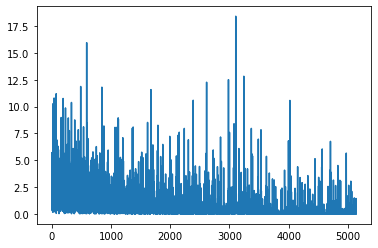

In [0]:
import matplotlib.pyplot as plt 
e_losses = []
criterion = nn.NLLLoss(size_average=False)
num_epochs = 20
for e in range(num_epochs):
    e_losses += train_epoch(net, opt, criterion)
    print("training:------")
    check_accuracy(net, torch.stack(X_train), y_train)
    print("testing:----")
    check_accuracy(net, X_test, y_test)
plt.plot(e_losses)
plt.show()

In [0]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')

In [0]:
X_test = torch.stack(X_test).to(device)

In [0]:
output = net(X_test)

In [0]:
y_test

[0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,


In [0]:
pred_test = list(output.argmax(dim=1, keepdim=True).numpy().reshape(1, -1)[0])

In [0]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, pred_test)

0.9660688317983519

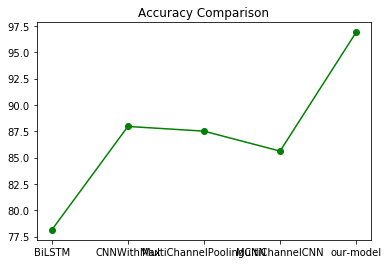

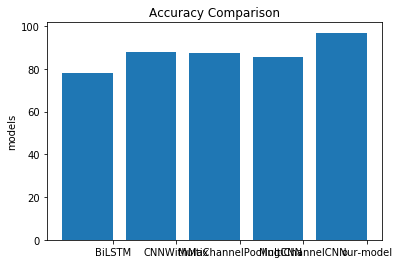

In [0]:
from matplotlib import pyplot as plt
models = ["BiLSTM","CNNWithMax","MultiChannelPoolingCNN","MultiChannelCNN",  "our-model"]
accuracy = [78.136,87.957, 87.510,85.617,96.897]
# create a line chart, years on x-axis, gdp on y-axis
plt.plot(models, accuracy, color='green', marker='o', linestyle='solid')
plt.title("Accuracy Comparison")
# add a label to the y-axis
# plt.ylabel("Billions of $")
plt.show()
xs = [i + 0.1 for i, _ in enumerate(models)]
plt.bar(xs, accuracy)
plt.ylabel("models")
plt.title("Accuracy Comparison")
plt.xticks([i + 0.5 for i, _ in enumerate(models)], models)
plt.show()